In [10]:
import random
import os.path
import pandas as pd
import numpy as np
import csv

from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

#from pyspark.sql import SQLContext, Row
#from pyspark.sql.types import *

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
def exists(filepath):
    return os.path.exists(filepath)

# Split 48 million rows to 10 million(training) & 38 million(testing)

In [3]:
if (exists('train10M.txt') and exists('test38M.txt')):
    print "train10M.txt and test38M.txt already created before."
else:
    !split -l 2000000 train.txt ff
    !cat ffaa ffat ffaf ffaq ffaj > train10M.txt
    !rm ffaa ffat ffaf ffaq ffaj
    !cat ff* > test38M.txt
    !rm ff*
    print "Newly created files: train10M.txt and test38M.txt."

train10M.txt and test38M.txt already created before.


# Split train10M data into 3 partitions

In [4]:
if (exists('train5M.txt') and 
    exists('validation2M.txt') and 
    exists('test3M.txt')):
    print "train5M.txt, validation2M.txt, test3M.txt already created before."
else:
    !split -l 1000000 train10M.txt ff
    !cat ffaa ffaj ffad ffaf ffah > train5M.txt    
    !cat ffai ffae > validation2M.txt
    !cat ffac ffag ffab > test3M.txt
    !rm ff*
    print "Newly created files: train5M.txt, validation2M.txt, test3M.txt."

train5M.txt, validation2M.txt, test3M.txt already created before.


# Plot histograms and store images

In [19]:
for col in range(1,40):
    filepath = 'histo-file/f%d.txt' % col
    imgpath = 'histo-img/f%d.png' % col
    title = 'feature %d' % col

    histo_df = pd.read_csv(filepath, header=None, names=["val", "freq"])
    ax = histo_df.plot(x='val', y='freq', logy='True', title=title, xlim=(0), figsize=(25,10))
    fig = ax.get_figure()
    fig.savefig(imgpath)
print "Histogram plot completed!"

Histogram plot completed!


# Select categorical features that should be kept out of all 26 possible cases

In [20]:
selected_categ_cols = [14,15,18,19,21,22,26,27,30,32,33,35,36,38]
len(selected_categ_cols)

14

# Normalize integer cols and compute rate-value on categorical cols

In [24]:
def get_train_xy(mdf, selected_categorical_cols):
    """
        normalize integer columns of dataframe and perform weighted freq count on selected categorical columns
        @param mdf: massive/large dataframe to be operated on (cols 1-13 are assumed to be integer columns)
        @param selected_categ_cols: hashed string columns to be converted to float values
        @return X: dataframe same as mdf but with 1 less column than mdf
        @return y: 1D array
    """
    int_cols = range(1,14)
    cols_to_keep = int_cols + selected_categorical_cols  
    y = mdf[0].values
    X = mdf[cols_to_keep].fillna(0)
    print "X and y extracted..."
    
    # normalize integers features
    X[int_cols] = X[int_cols].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
    print "X normalization complete..."
    
    # compute weighted freq: each column entry is freq/cumulative_freq
    cum_freq = len(mdf) * 1.0
    for col in selected_categorical_cols:
        freq = m_count_distinct(X[col].values)
        X[col] = X[col].apply(lambda x: freq.get(x)/cum_freq) 
    print "Data preparation complete!"

    return X, y

def m_count_distinct(col):
    """
        count distinct values in all columns
        @param col: numpy 1D array
        @return: dictionary of value, freq
    """
    d = {}
    for x in list(col):
        if type(x) == np.float64 and np.isnan(x):
            k = 'nan-' + col
            d[k] = d.get(k, 0) + 1
        else:
            d[x] = d.get(x, 0) + 1
    return d

def score_higher_freq(y):
    """
        accuracy score for baseline method that always predicts the value with higher frequency
        @param y: 1D array
        @return: float value between 0.0 and 1.0
    """
    d = {}
    for i in y:
        d[i] = d.get(i,0) + 1
    return max(d.values())/float(len(y))

# Prepare training and validation data

In [25]:
df_train = pd.read_table('train5M.txt', header=None)
X_train, y_train = get_train_xy(df_train, selected_categ_cols)

X and y extracted...
X normalization complete...
Data preparation complete!


In [26]:
df_va = pd.read_table('validation2M.txt', header=None)
X_va, y_va = get_train_xy(df_va, selected_categ_cols)

X and y extracted...
X normalization complete...
Data preparation complete!


# Compute baseline score that always predicts value with higher freq

In [27]:
print "Baseline score:", score_higher_freq(y_va)

Baseline score: 0.7459995


# Fit models and predict

In [28]:
model_NB = GaussianNB()
model_NB.fit(X_train, y_train)
predicted_NB = model_NB.predict(X_va)

model_NB

GaussianNB()

In [29]:
model_LR = LogisticRegression()
model_LR.fit(X_train, y_train)
predicted_LR = model_LR.predict(X_va)

model_LR

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [34]:
model_RF = RandomForestClassifier(n_estimators=10)
model_RF.fit(X_train, y_train)
predicted_RF = model_RF.predict(X_va)

model_RF

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

# ROC curves, Accuracy scores, AUC scores

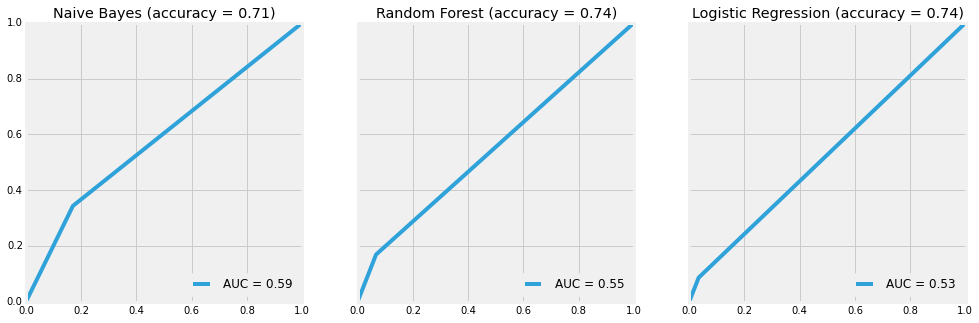

In [36]:
%matplotlib inline

y_predictions = {
    'Naive Bayes': predicted_NB,
    'Logistic Regression': predicted_LR,
    'Random Forest': predicted_RF,
}

fig, axes = plt.subplots(1, len(y_predictions), sharey=True)
fig.set_size_inches(15,5)
i = 0

for title, prediction in y_predictions.items():
    accuracy = metrics.accuracy_score(y_va, prediction)
    fulltitle = title + ' (accuracy = %0.2f)' % accuracy
    fpr, tpr, thresholds = metrics.roc_curve(y_va, prediction, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    label = 'AUC = %0.2f' % auc

    axes[i].plot(fpr, tpr, label=label)
    axes[i].set_title(fulltitle)
    axes[i].legend(loc='lower right')
    i += 1

# Test 3M

In [37]:
df_test = pd.read_table('test3M.txt', header=None)
X_test, y_test = get_train_xy(df_test, selected_categ_cols)

X and y extracted...
X normalization complete...
Data preparation complete!


In [38]:
predicted_test = model_LR.predict(X_test)
print "Test3M accuracy:", metrics.accuracy_score(y_test, predicted_test)
print "Test3M auc:", metrics.roc_auc_score(y_test, predicted_test)

Test3M accuracy: 0.745243
Test3M auc: 0.534841102077
